## Get data

### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

#### Train

In [2]:
X_set_0_path = glob.glob("data/normal/*.jpeg")
X_set_1_path = glob.glob("data/pneumonia/*.jpeg")

In [3]:
X_set_0 = []
X_set_1 = []

In [4]:
for path_0, path_1 in zip(X_set_0_path, X_set_1_path):
    X_set_0.append(cv2.imread(path_0, 0))
    X_set_1.append(cv2.imread(path_1, 0))

## Preview

In [5]:
sample_0 = X_set_0[0]
sample_1 = X_set_1[0]

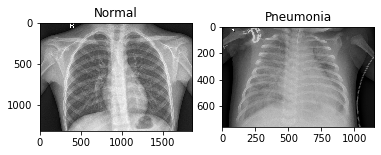

In [6]:
f, axarr = plt.subplots(1,2)
axarr[0].set_title("Normal")
axarr[0].imshow(sample_0, cmap="gray")
axarr[1].set_title("Pneumonia")
axarr[1].imshow(sample_1, cmap="gray")

plt.show()

In [7]:
print(f"sample 0: {sample_0.shape}")
print(f"sample 1: {sample_1.shape}")

sample 0: (1317, 1857)
sample 1: (760, 1152)


## Preprocess

In [8]:
def preprocess_CNN(list_img):
    list_prepross = []
    for img in list_img:
        tmp = img.copy()
        tmp = cv2.resize(tmp, (200, 200), interpolation = cv2.INTER_AREA)
        tmp = tmp.reshape(200, 200, 1)
        list_prepross.append(tmp)
    return np.array(list_prepross)

#### Normalize

In [9]:
X_set_0_preprocess = preprocess_CNN(X_set_0).astype('float32') / 255.0
X_set_1_preprocess = preprocess_CNN(X_set_1).astype('float32') / 255.0

#### Concat

In [10]:
X = np.concatenate((X_set_0_preprocess, X_set_1_preprocess))
y = [0 for i in range(len(X_set_0_preprocess))] + [1 for i in range(len(X_set_1_preprocess))]

In [11]:
print(f"x_train len: {len(X)}")
print(f"y_train len: {len(y)}")

x_train len: 814
y_train len: 814


#### Shuffle

In [12]:
import random

In [13]:
X_y = list(zip(X, y))
random.shuffle(X_y)
X, y = zip(*X_y)

#### Split train_test

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
print(f"X_train: {len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}")

X_train: 545, X_test: 269, y_train: 545, y_test: 269


In [17]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],)
y_test = np.array(y_test)
y_test = y_test.reshape(y_test.shape[0],)

In [18]:
X_train.shape

(545, 200, 200, 1)

#### Validation setup

In [19]:
val_size = 20

X_val = X_train[:val_size]
y_val = y_train[:val_size]

X_train = X_train[val_size:]
y_train = y_train[val_size:]

In [20]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}")

X_train: (525, 200, 200, 1), X_test: (269, 200, 200, 1), y_train: (525,), y_test: (269,), X_val: (20, 200, 200, 1), y_val: (20,)


## CNN

In [21]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models

In [22]:
in_shape = X_train.shape[1:]
n_classes = len(np.unique(y_train))
print(in_shape, n_classes)

(200, 200, 1) 2


In [23]:
model = Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=in_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 147456)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                9437248   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=35, batch_size=35, steps_per_epoch=15,
                    validation_data=(X_test, y_test))

Train on 525 samples, validate on 269 samples
Epoch 1/35
525/525 [==============================] - 4s 8ms/sample - loss: 0.6802 - accuracy: 0.5581 - val_loss: 0.6671 - val_accuracy: 0.5204
Epoch 2/35
525/525 [==============================] - 2s 3ms/sample - loss: 0.6551 - accuracy: 0.6362 - val_loss: 0.6596 - val_accuracy: 0.4907
Epoch 3/35
525/525 [==============================] - 2s 3ms/sample - loss: 0.6415 - accuracy: 0.6476 - val_loss: 0.6232 - val_accuracy: 0.7509
Epoch 4/35
525/525 [==============================] - 2s 3ms/sample - loss: 0.6151 - accuracy: 0.6705 - val_loss: 0.5981 - val_accuracy: 0.7286
Epoch 5/35
525/525 [==============================] - 2s 3ms/sample - loss: 0.5897 - accuracy: 0.7829 - val_loss: 0.5735 - val_accuracy: 0.8550
Epoch 6/35
525/525 [==============================] - 2s 3ms/sample - loss: 0.5595 - accuracy: 0.8571 - val_loss: 0.5538 - val_accuracy: 0.8550
Epoch 7/35
525/525 [==============================] - 2s 3ms/sample - loss: 0.5409 - accur

## Evaluate 

20/20 - 0s - loss: 0.2207 - accuracy: 0.9500


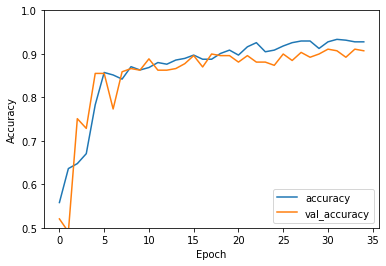

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_val,  y_val, verbose=2)

## Predict

In [27]:
def validator(threshold, predict_val, label):
    if label:
        if predict_val > threshold:
            return "True Positive"
        else:
            return "False negative"
    else:
        if predict_val < threshold:
            return "True negative"
        else:
            return "False positive"

In [28]:
threshold = 0.4 # curseur selon si on préfère le cout ou le risque minimum
for i in range(val_size):
    predicted = model.predict(np.array([X_val[i]]), verbose=0).round(2)
    print(f"true label: {y_val[i]}, predicted: {predicted}, result: {validator(threshold, predicted, y_val[i])}")

true label: 0, predicted: [[0.02]], result: True negative
true label: 0, predicted: [[0.06]], result: True negative
true label: 1, predicted: [[0.96]], result: True Positive
true label: 0, predicted: [[0.04]], result: True negative
true label: 1, predicted: [[0.69]], result: True Positive
true label: 0, predicted: [[0.29]], result: True negative
true label: 0, predicted: [[0.07]], result: True negative
true label: 0, predicted: [[0.17]], result: True negative
true label: 1, predicted: [[0.69]], result: True Positive
true label: 1, predicted: [[0.82]], result: True Positive
true label: 1, predicted: [[0.38]], result: False negative
true label: 0, predicted: [[0.14]], result: True negative
true label: 0, predicted: [[0.07]], result: True negative
true label: 0, predicted: [[0.18]], result: True negative
true label: 0, predicted: [[0.11]], result: True negative
true label: 0, predicted: [[0.26]], result: True negative
true label: 1, predicted: [[0.93]], result: True Positive
true label: 1